## Klasterisasi Aktivitas dan Kinerja Akademik Menggunakan Alogirtma Average Linkage

### Load Dataset

Membaca file dataset menggunakan library pandas

In [44]:
import pandas as pd

# Load dataset
FILE_PATH = 'data/student_lifestyle_dataset.csv'
data = pd.read_csv(FILE_PATH)
data.head(5)

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


### Preprocessing

Pada langkah ini, kita ingin menormalisasikan fitur numerik dengan melakukan perubahan atau encode variabel kategori seperti Stress Level menjadi bentuk angka untuk memastikan variabel dapat dengan mudah dikomparasi. Kita juga melakukan standarisasi skala supaya tidak ada fitur yang dominan karena skala nya yang lebih besar dibanding dengan fitur yang lain

In [45]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


stress_level_mapping = {"Low": 1, "Moderate": 2, "High": 3}
data['Stress_Level_Encoded'] = data['Stress_Level'].map(stress_level_mapping)

numerical_cols = [
    "Study_Hours_Per_Day", 
    "Extracurricular_Hours_Per_Day", 
    "Sleep_Hours_Per_Day", 
    "Social_Hours_Per_Day", 
    "Physical_Activity_Hours_Per_Day", 
    "GPA",
    'Stress_Level_Encoded'
]

data_numeric = data[numerical_cols]

# Normalize with StandardScaler 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

data_scaled.mean(axis=0)

array([-3.15303339e-16,  1.42108547e-17,  1.77635684e-16, -1.40332190e-16,
       -5.46673817e-16,  5.22248911e-16, -1.07469589e-16])

### Klasterisasi

Pada tahap ini, kita melakukan klasterisasi dengan method average linkage menggunakan library scipy. Untuk kalkukasi jarak dalam kodingan sudah ditangani oleh library scipy sendiri.

In [5]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

linkage_matrix = linkage(data_scaled, method='average')

c, coph_dists = cophenet(linkage_matrix, pdist(data_scaled))
c

0.5653802294969428

### Visualisasi Dendogram

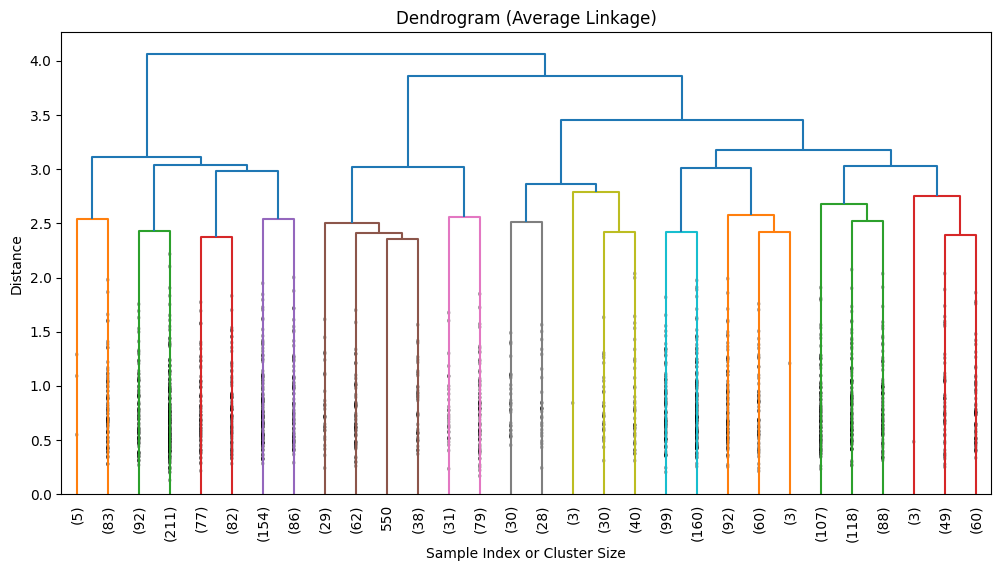

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title("Dendrogram (Average Linkage)")
plt.xlabel("Sample Index or Cluster Size")
plt.ylabel("Distance")
plt.show()

### Mencari jumlah kluster yang optimal

Menggunakan elbow method dan silhoutte score

#### Elbow Method

In [7]:
from sklearn.cluster import AgglomerativeClustering

def wss_calculation(K, data):
    WSS = []
    for i in range(K):
        cluster = AgglomerativeClustering(n_clusters=i+1, linkage='average')
        cluster.fit_predict(data)
        # cluster index
        label = cluster.labels_
        wss = []
        for j in range(i+1):
            # extract each cluster according to its index
            idx = [t for t, e in enumerate(label) if e == j]
            cluster = data[idx,]
            # calculate the WSS:
            cluster_mean = cluster.mean(axis=0)
            distance = np.sum(np.abs(cluster - cluster_mean)**2,axis=-1)
            wss.append(sum(distance))
        WSS.append(sum(wss))
    return WSS

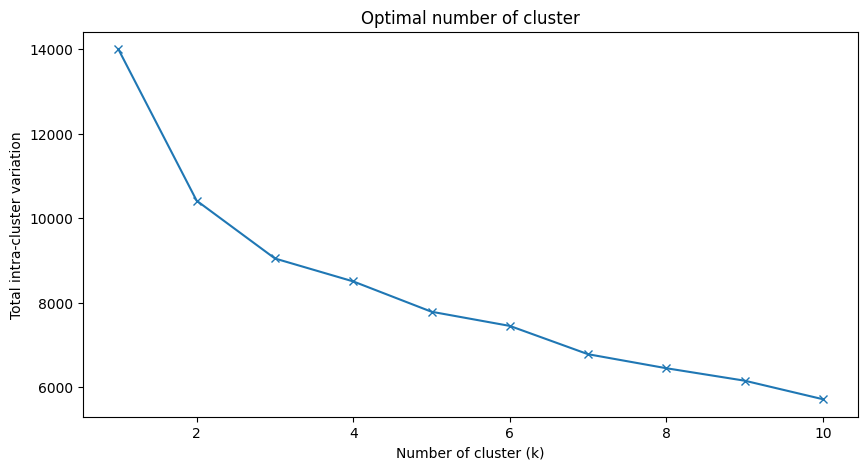

In [9]:
import numpy as np

WSS=wss_calculation(10, data_scaled)

cluster_range = range(1, 11)

plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster')
plt.xlabel('Number of cluster (k)')
plt.ylabel('Total intra-cluster variation')
plt.plot(cluster_range, WSS, marker = "x")

Berdasarkan hasil dan pengamatan menggunakan elbow method pada diatas, maka kita mendeduksikan 3 sebagai jumlah klaster yang optimal. Hal ini dikarenakan penurunan total variasi intra-cluster sangat besar antara k = 1 hingga k = 3, namun laju penurunannya melambat secara signifikan setelah k = 3.

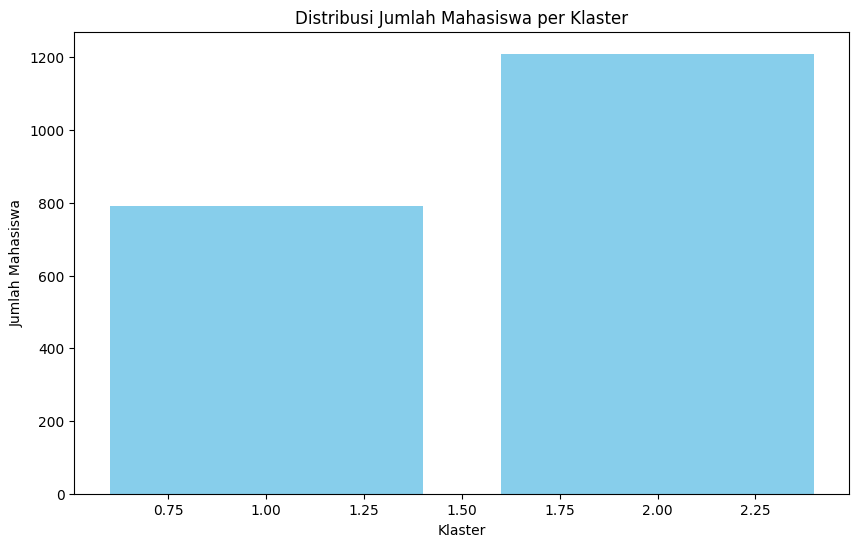

In [46]:
num_clusters = 2

clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

data['Cluster'] = clusters

numeric_columns = data.select_dtypes(include=['number']).columns

cluster_counts = data['Cluster'].value_counts().sort_index()

cluster_centers = data[numeric_columns].groupby('Cluster').mean()

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.title("Distribusi Jumlah Mahasiswa per Klaster")
plt.xlabel("Klaster")
plt.ylabel("Jumlah Mahasiswa")
plt.show()

In [56]:
data.columns = data.columns.str.strip()


detailed_summary = data.drop(columns=['Student_ID'])

detailed_summary = detailed_summary.groupby('Cluster')[numerical_cols].describe()
detailed_summary = data.groupby('Cluster')[numerical_cols].describe()

pd.set_option('display.max_columns', None) 
pd.set_option('display.width', None)  

detailed_summary


Study_Hours_Per_Day                                                \
                      count      mean       std  min  25%  50%  75%   max   
Cluster                                                                     
1                     790.0  8.950253  0.633352  6.4  8.5  9.0  9.5  10.0   
2                    1210.0  6.513140  0.861645  5.0  5.8  6.5  7.2   8.6   

        Extracurricular_Hours_Per_Day                                          \
                                count      mean       std  min  25%  50%  75%   
Cluster                                                                         
1                               790.0  2.012911  1.162570  0.0  1.0  2.0  3.1   
2                              1210.0  1.975207  1.151687  0.0  1.0  2.0  2.9   

             Sleep_Hours_Per_Day                                            \
         max               count      mean       std  min    25%  50%  75%   
Cluster                                                                      
1        4.0               790.0  7.524051  1.460551  5.0  6.225  7.6  8.8   
2        4.0              1210.0  7.486364  1.461620  5.0  6.200  7.5  8.8   

              Social_Hours_Per_Day                                          \
          max                count      mean       std  min  25%  50%  75%   
Cluster                                                                      
1        10.0                790.0  2.506582  1.648084  0.0  1.1  2.3  3.8   
2        10.0               1210.0  2.833802  1.702688  0.0  1.3  2.8  4.3   

             Physical_Activity_Hours_Per_Day                                \
         max                           count      mean       std  min  25%   
Cluster                                                                      
1        6.0                           790.0  3.006203  1.869195  0.0  1.5   
2        6.0                          1210.0  5.191488  2.506577  0.0  3.3   

                            GPA                                                \
         50%  75%   max   count      mean       std   min  25%    50%     75%   
Cluster                                                                         
1        2.8  4.3   8.8   790.0  3.351532  0.221672  2.65  3.2  3.360  3.5075   
2        5.1  7.0  13.0  1210.0  2.962157  0.235566  2.24  2.8  2.965  3.1200   

              Stress_Level_Encoded                                              
          max                count      mean      std  min  25%  50%  75%  max  
Cluster                                                                         
1        4.00                790.0  3.000000  0.00000  3.0  3.0  3.0  3.0  3.0  
2        3.75               1210.0  1.952066  0.66411  1.0  2.0  2.0  2.0  3.0

In [12]:
# Visualize GPA distribution per cluster
def visualize_distribution(col):
    plt.figure(figsize=(10, 6))
    for cluster in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster]
        plt.hist(cluster_data[col], bins=10, alpha=0.5, label=f'Cluster {cluster}')
    plt.title(f"{col} Distribution per Cluster")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

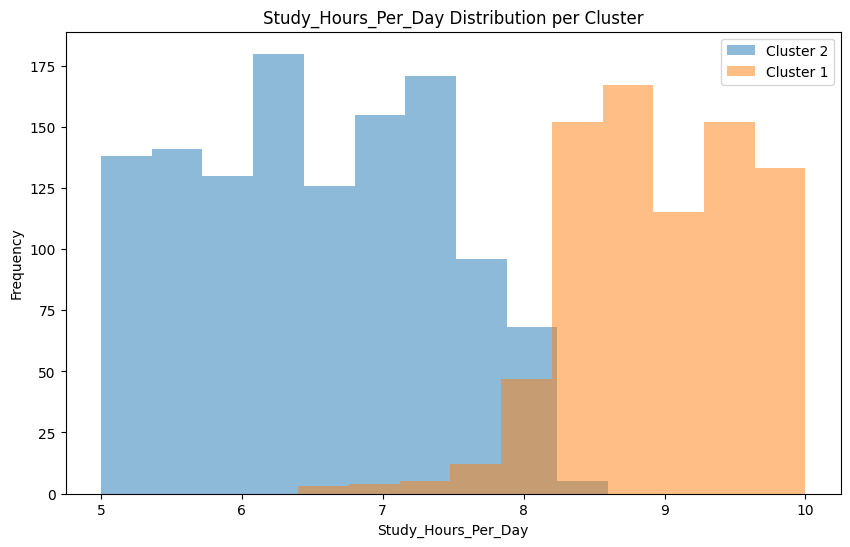

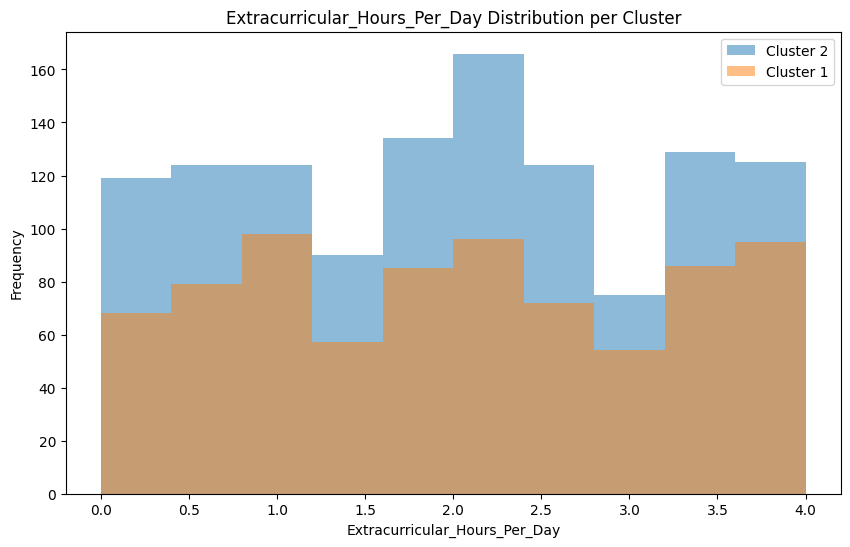

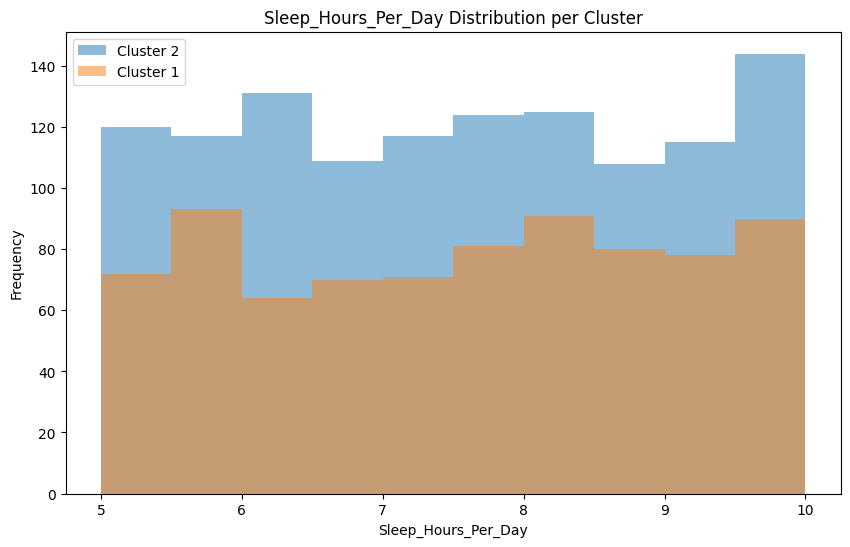

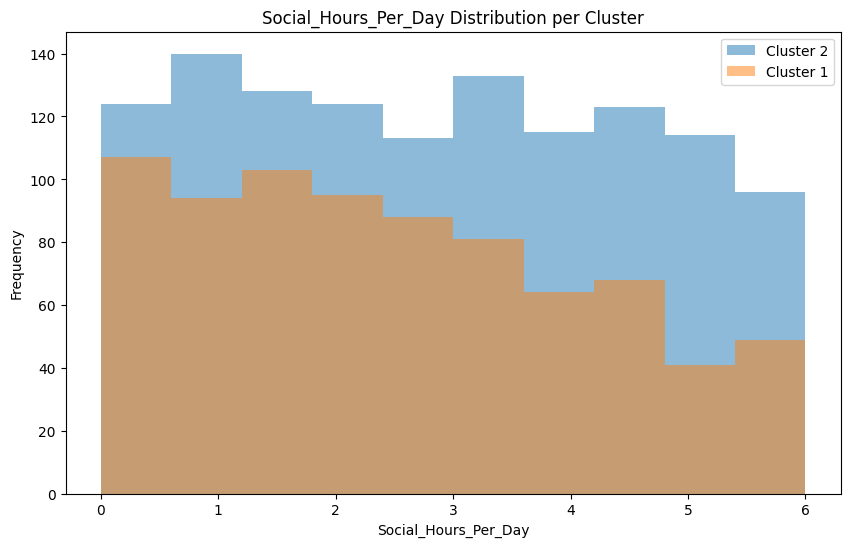

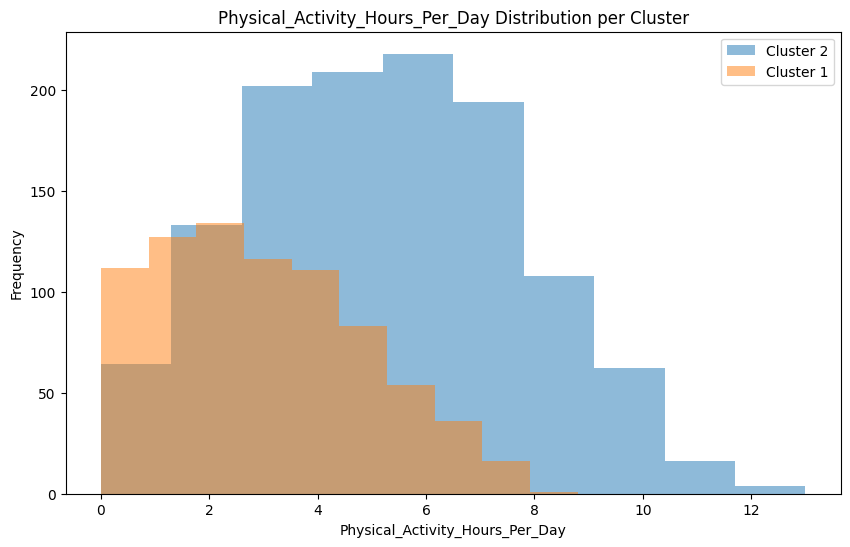

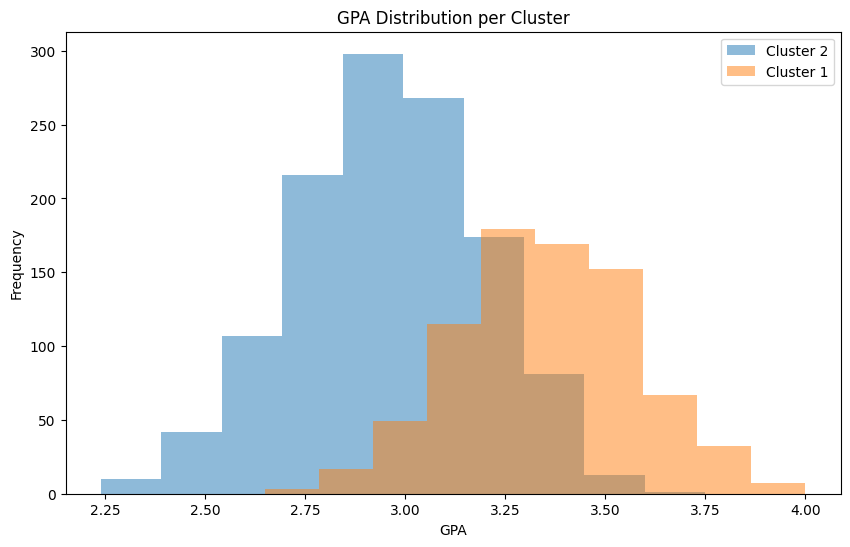

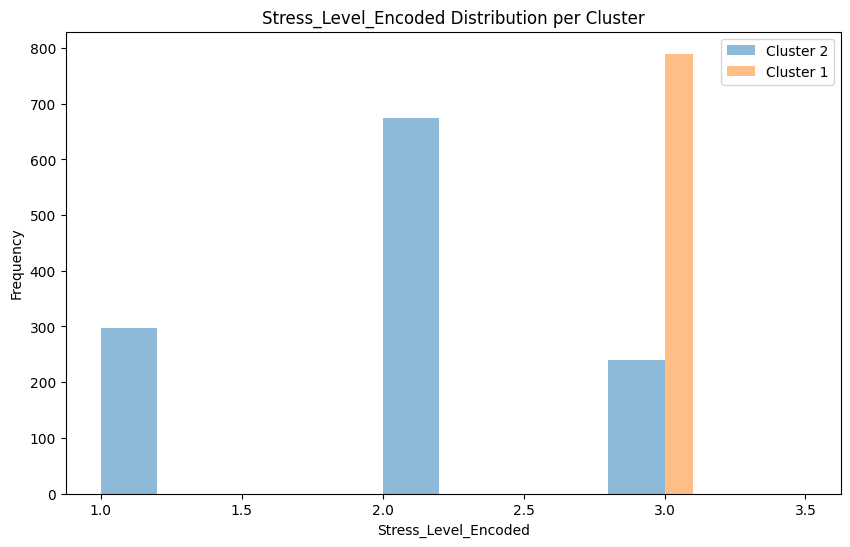

In [57]:
for num_col in numerical_cols :
    visualize_distribution(num_col)